In [4]:
import os
import numpy as np
import skimage.io as io
from pycocotools import coco, mask as maskUtils
from PIL import Image
import torch
from torchvision import transforms
import cv2

# Load annotation files
rgbAnnFile = './aauRainSnow-rgb.json'
thermalAnnFile = './aauRainSnow-thermal.json'
rainSnowRgbGt = coco.COCO(rgbAnnFile)
rainSnowThermalGt = coco.COCO(thermalAnnFile)

def coco_ann_to_mask(ann, height, width):
    seg = ann.get('segmentation', None)
    if not seg:
        raise ValueError("Missing segmentation")
    if isinstance(seg, list):
        if len(seg) == 0:
            raise ValueError("Empty segmentation list")
        rles = maskUtils.frPyObjects(seg, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(seg, dict) and 'counts' in seg:
        rle = seg
    else:
        raise ValueError("Invalid segmentation format")
    return maskUtils.decode(rle)

def build_aau_dataset(rainSnowRgbGt, rainSnowThermalGt, target_size=(224, 224), max_images=2197):
    dataset = []

    tf_rgb = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    tf_thermal = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for i in range(max_images):
        annIds = rainSnowRgbGt.getAnnIds(imgIds=[i])
        anns = rainSnowRgbGt.loadAnns(annIds)

        if not anns:
            continue

        rgb_info = rainSnowRgbGt.loadImgs([i])[0]
        thermal_info = rainSnowThermalGt.loadImgs([i])[0]
        thermal_anns = rainSnowThermalGt.loadAnns(annIds)

        try:
            rgb_img = io.imread('./' + rgb_info['file_name'])
            thermal_img = io.imread('./' + thermal_info['file_name'])
        except Exception as e:
            print(f"Error reading image {i}: {e}")
            continue

        height, width = rgb_img.shape[:2]
        combined_mask = np.zeros((height, width), dtype=np.uint8)

        for ann in anns:
            try:
                cat_id = ann['category_id']
                mask = coco_ann_to_mask(ann, height, width)
                combined_mask = np.maximum(combined_mask, mask * cat_id)
            except Exception as e:
                print(f"Skipping ann {ann.get('id')} in image {i}: {e}")

        if len(thermal_img.shape) == 3:
            thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)

        try:
            rgb_tensor = tf_rgb(rgb_img)
            thermal_tensor = tf_thermal(thermal_img)
            mask_tensor = torch.from_numpy(np.array(
                transforms.Resize(target_size, interpolation=Image.NEAREST)(
                    Image.fromarray(combined_mask)
                )
            )).long()
        except Exception as e:
            print(f"Error transforming image {i}: {e}")
            continue

        dataset.append({
            'id': i,
            'file_name': rgb_info['file_name'],
            'rgb': rgb_tensor,
            'thermal': thermal_tensor,
            'mask': mask_tensor
        })

    print(f"Dataset built with {len(dataset)} samples.")
    return dataset


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [5]:
dataset = build_aau_dataset(rainSnowRgbGt, rainSnowThermalGt, target_size=(224, 224))

# Print the first few samples
for sample in dataset[:3]:
    print(f"\nID: {sample['id']}, File: {sample['file_name']}")
    print(f"RGB: {sample['rgb'].shape}, Thermal: {sample['thermal'].shape}, Mask: {sample['mask'].shape}")


Skipping ann 626 in image 109: Missing segmentation
Skipping ann 362 in image 110: Missing segmentation
Skipping ann 627 in image 111: Missing segmentation
Skipping ann 365 in image 112: Missing segmentation
Skipping ann 367 in image 113: Missing segmentation
Skipping ann 370 in image 114: Missing segmentation
Skipping ann 373 in image 115: Missing segmentation
Skipping ann 376 in image 116: Missing segmentation
Skipping ann 379 in image 117: Missing segmentation
Skipping ann 628 in image 130: Missing segmentation
Skipping ann 413 in image 131: Missing segmentation
Skipping ann 417 in image 132: Missing segmentation
Skipping ann 421 in image 133: Missing segmentation
Skipping ann 629 in image 152: Missing segmentation
Skipping ann 467 in image 153: Missing segmentation
Skipping ann 472 in image 154: Missing segmentation
Skipping ann 479 in image 155: Missing segmentation
Skipping ann 486 in image 156: Missing segmentation
Skipping ann 493 in image 157: Missing segmentation
Skipping ann

In [6]:
from torch.utils.data import Dataset

class AAUDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {
            'rgb': sample['rgb'],
            'thermal': sample['thermal'],
            'mask': sample['mask'],
            'id': sample['id'],
            'file_name': sample['file_name']
        }


In [7]:
from torch.utils.data import random_split

full_dataset = AAUDataset(dataset)
total = len(full_dataset)

train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 1419, Val: 304, Test: 305


In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


In [9]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=150,  # TEMP: change to match your category count
    ignore_mismatched_sizes=True  # Needed if your number of labels doesn't match ADE20K
)


c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tricks\.cache\huggingface\hub\models--nvidia--segformer-b0-finetuned-ade-512-512. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or

In [14]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        inputs = batch['rgb'].to(device)
        masks = batch['mask'].to(device)

        outputs = model(pixel_values=inputs).logits  # [B, num_classes, H_out, W_out]
        # Resize logits to match target mask size
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)



In [15]:
epochs = 10
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")


Epoch 1/10, Loss: 0.4042
Epoch 2/10, Loss: 0.1195
Epoch 3/10, Loss: 0.0808
Epoch 4/10, Loss: 0.0624
Epoch 5/10, Loss: 0.0507
Epoch 6/10, Loss: 0.0424
Epoch 7/10, Loss: 0.0380
Epoch 8/10, Loss: 0.0334
Epoch 9/10, Loss: 0.0317
Epoch 10/10, Loss: 0.0282


In [16]:
import torch.nn.functional as F

def evaluate_model(model, loader):
    model.eval()
    total_correct = 0
    total_pixels = 0
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            inputs = batch['rgb'].to(device)
            masks = batch['mask'].long().to(device)

            outputs = model(pixel_values=inputs).logits
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

    accuracy = total_correct / total_pixels
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss



In [17]:
test_accuracy, test_loss = evaluate_model(model, test_loader)
print(f"\nTest Loss: {test_loss:.4f}, Test Pixel Accuracy: {test_accuracy * 100:.2f}%")



Test Loss: 0.0278, Test Pixel Accuracy: 99.10%


In [18]:
import matplotlib.pyplot as plt

def visualize_sample(sample, model):
    model.eval()
    with torch.no_grad():
        rgb = sample['rgb'].unsqueeze(0).to(device)
        mask = sample['mask']
        pred = model(pixel_values=rgb).logits
        pred = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(sample['rgb'].permute(1, 2, 0).numpy())
    axs[0].set_title('RGB Image')
    axs[1].imshow(mask.numpy())
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred)
    axs[2].set_title('Prediction')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


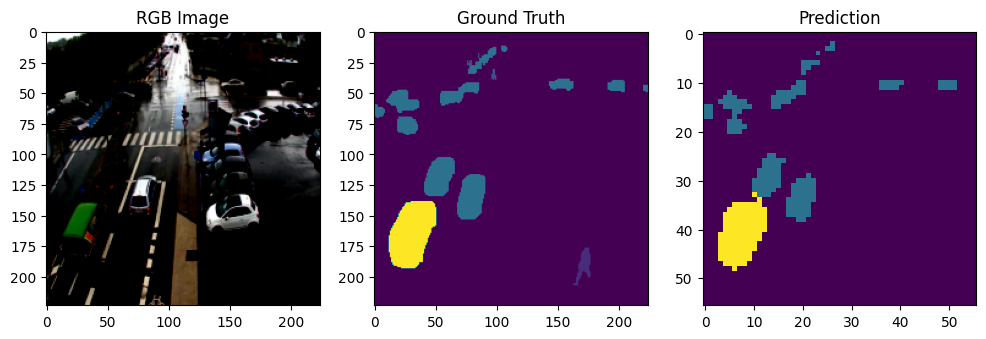

In [20]:
visualize_sample(test_dataset[20], model)
